<a href="https://colab.research.google.com/github/sayakpaul/deploy-hf-tf-vision-models/blob/main/locust/load_test_results_vit_gke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to compare load-test results of ViT model from 🤗 Transformers on GKE

## Download reports


In [2]:
!wget -q https://github.com/sayakpaul/deploy-hf-tf-vision-models/releases/download/1.0/loadtest-results.tar.gz

## Extract downloaded reports

All the reports should be placed under `/content/reports` folder

In [4]:
!mkdir reports
!tar -xvf loadtest-results.tar.gz -C reports --strip-components=1

mkdir: cannot create directory ‘reports’: File exists
loadtest-results/c2-8vCPU+32GB+inter_op4_stats_history.csv
loadtest-results/n1-8vCPU+32GB+inter_op4_stats_history.csv
loadtest-results/n2-8vCPU+32GB+inter_op4_stats_history.csv


## Preprocess

### Imports

In [5]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

### Preprocessing

`reports` contains every information required to draw the resulting graphs. Initially, there are two keys (`name` and `filename`), but one more key (`df`) will be inserted with `pd.read_csv` later. Add any additional reports to be inspected in `reports`.

In [6]:
reports = [
  {
      "name": "c2-2n-8c-32r-interop4",
      "filename": "c2-8vCPU+32GB+inter_op4_stats_history.csv"
  },  
  {
      "name": "n2-2n-8c-32r-interop4",
      "filename": "n2-8vCPU+32GB+inter_op4_stats_history.csv"
  },
  {
      "name": "n1-2n-8c-32r-interop4",
      "filename": "n1-8vCPU+32GB+inter_op4_stats_history.csv"
  }
]

The names of some columns might be modified for better readibility. If you have any original columns to be displayed in different names, add them in `to_be_updated_columns`. You need to specify `old` and `new` column names.

In [7]:
to_be_updated_columns = [
  {
      "old": "Total Average Response Time",
      "new": "Total Average Response Time(ms)"
  },
  {
      "old": "Total Max Response Time",
      "new": "Total Max Response Time(ms)"
  }
]

def update_column_names(reports, to_be_updated_columns):
  for report in reports:
    for column in to_be_updated_columns:
      report['df'][column['new']] = report['df'][column['old']]

  return reports

Originally, the timestamp of the reports from locust is the actual time when the load test was measured. However, we are just interested in how much time has passed since the start of the load test. `set_timestamp_offsets` sets the timestamp of the first record `0` as the offset, and the rest timestamps are substracted by the first one.

In [8]:
def set_timestamp_offsets(reports):
  for report in reports:
    report["df"]["Timestamp"] = report["df"]["Timestamp"] - report["df"].head(1)["Timestamp"].tolist()[0]

  return reports

Preprocessing (main code)

In [9]:
for report in reports:
  report["df"] = pd.read_csv(f'reports/{report["filename"]}')

reports = update_column_names(reports, to_be_updated_columns)
reports = set_timestamp_offsets(reports)

##  Graph functions

`draw_graph` draws a graph of the intersting columns from every dtaframes in `reports`. X axis is set to `Timestamp` by default, and the legend of each report is set to the `name` from the dictionary entry in `reports`.

In [10]:
def draw_graph(reports, axis, title, x="Timestamp"):
  y = title
  axis.set_title(title)
  for report in reports:
    axis.plot(report["df"][x], report["df"][y], label=report["name"])
  axis.set_xlabel(x)
  axis.legend()
  return axis

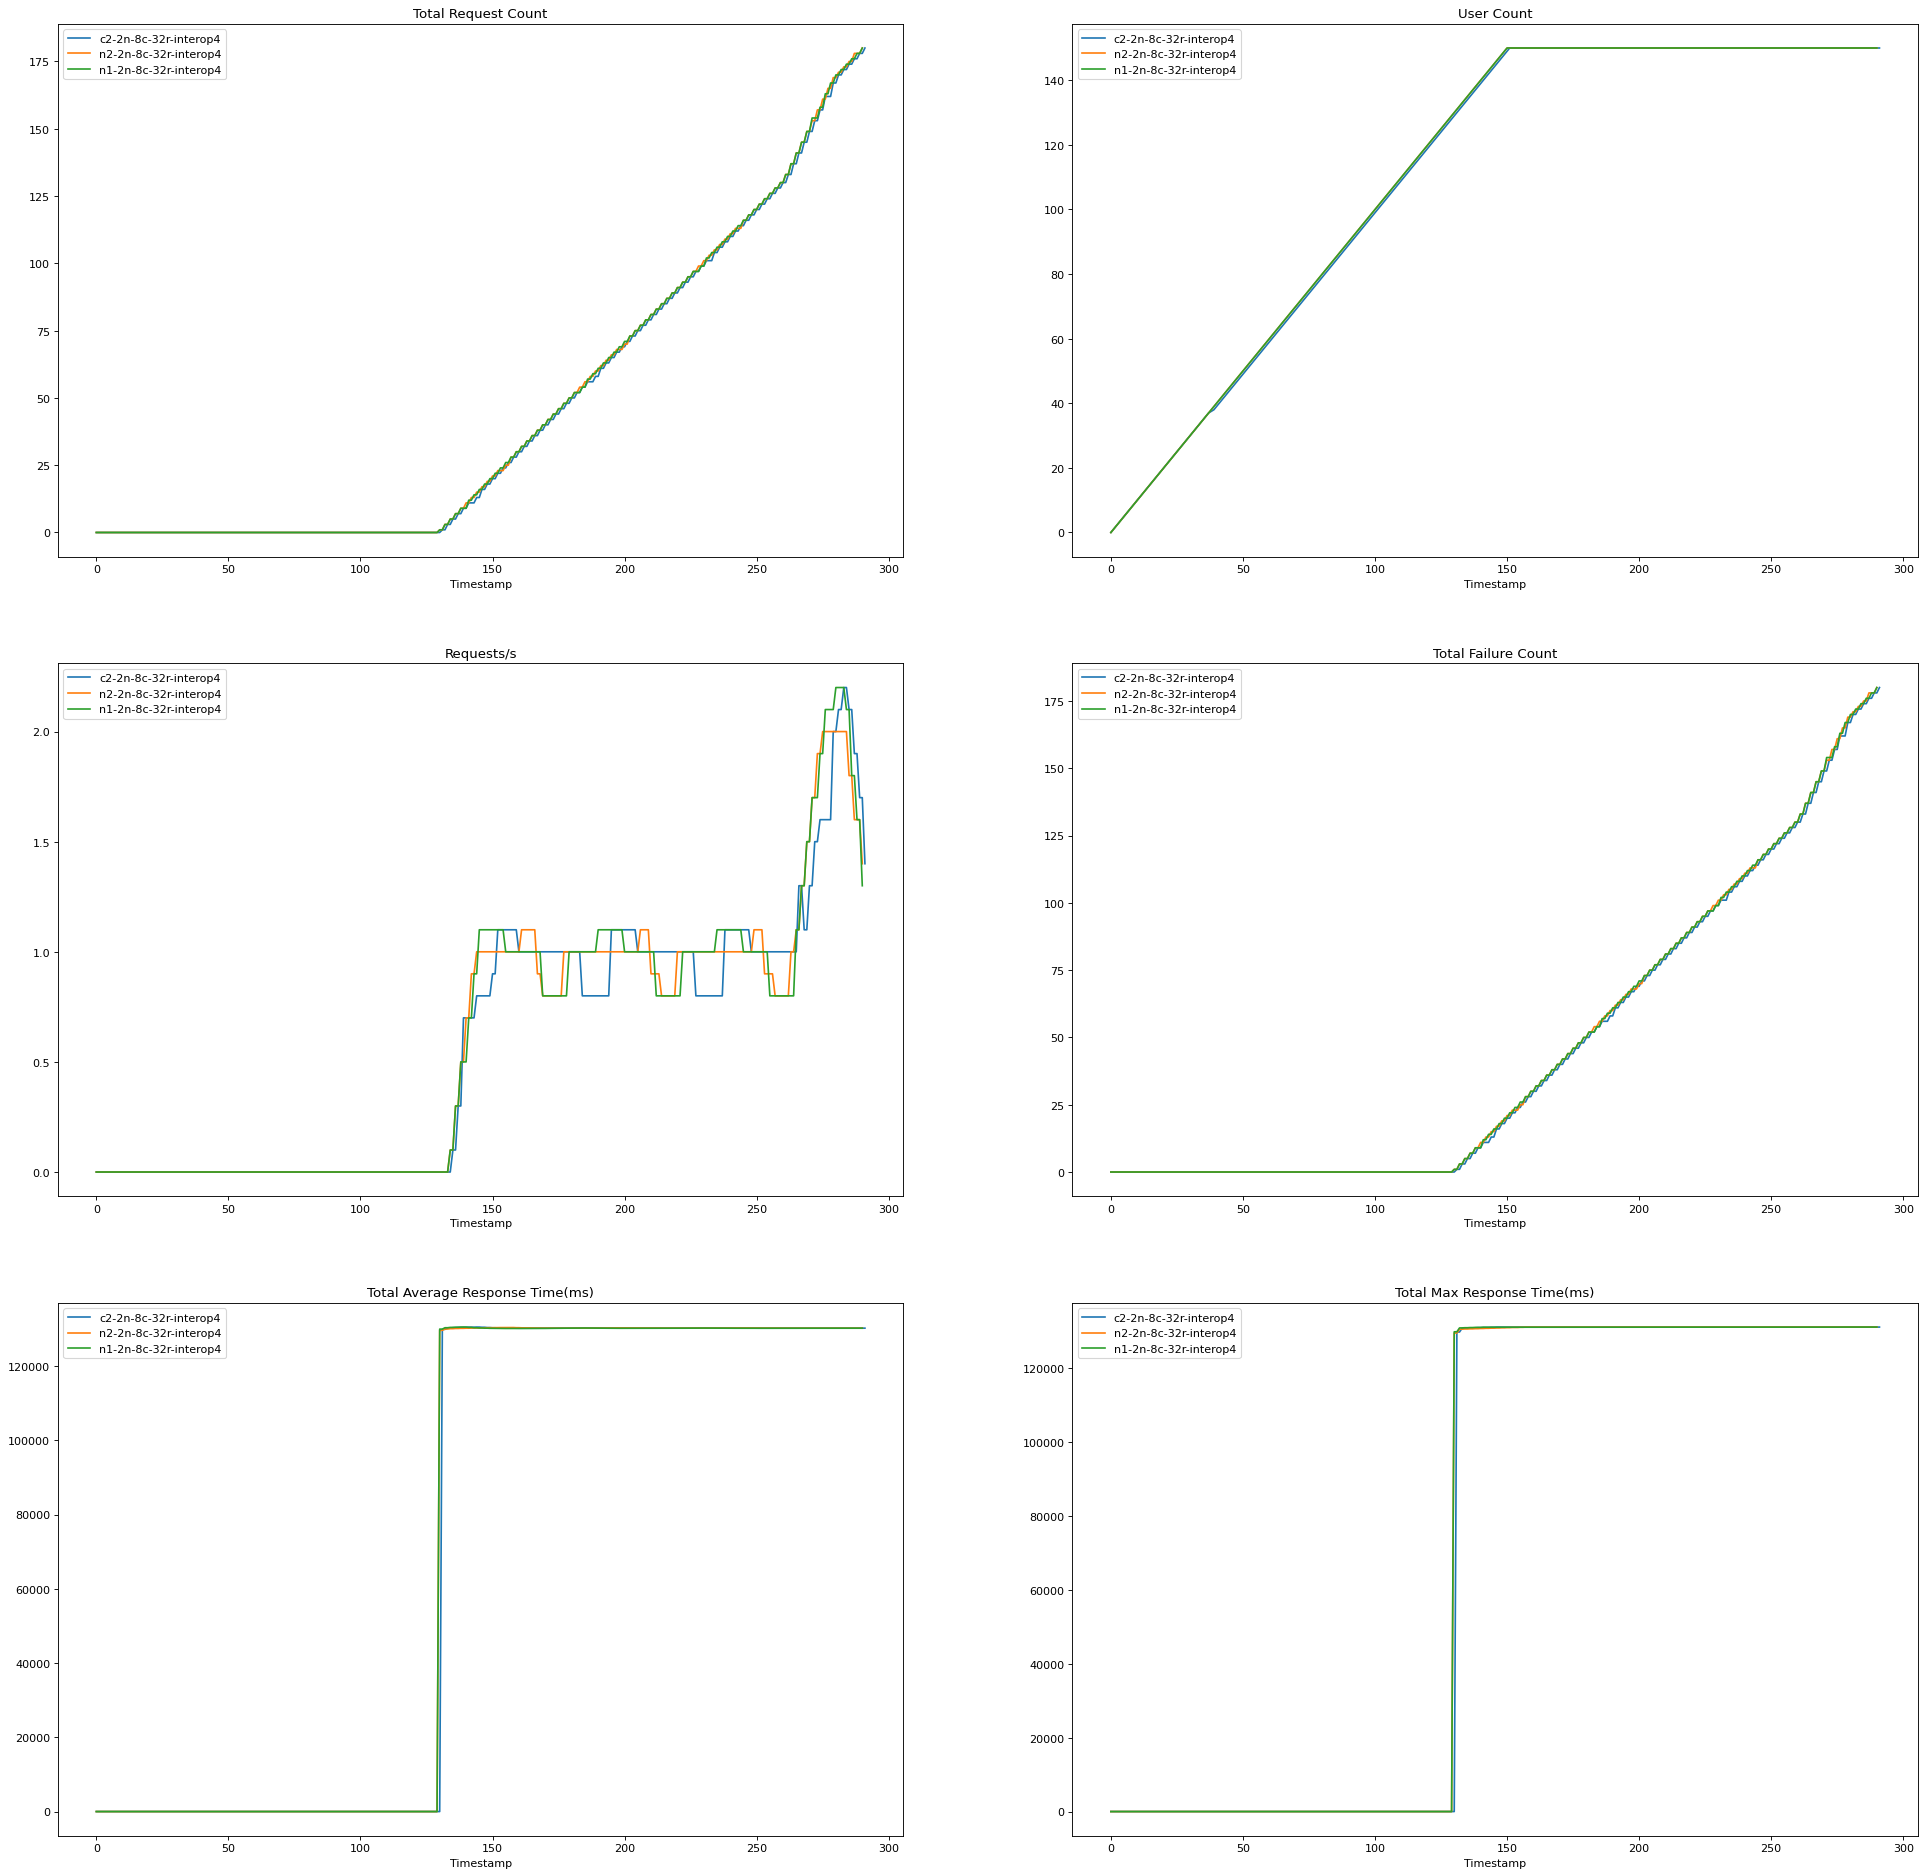

In [11]:
figure, axis = plt.subplots(3, 2, figsize=(30,30), dpi=80)

axis[0, 0] = draw_graph(reports, axis[0, 0], 'Total Request Count')
axis[0, 1] = draw_graph(reports, axis[0, 1], 'User Count')
axis[1, 0] = draw_graph(reports, axis[1, 0], 'Requests/s')
axis[1, 1] = draw_graph(reports, axis[1, 1], 'Total Failure Count')
axis[2, 0] = draw_graph(reports, axis[2, 0], 'Total Average Response Time(ms)')
axis[2, 1] = draw_graph(reports, axis[2, 1], 'Total Max Response Time(ms)')

plt.show()